# Machine Learning Model for depature predictions electrical vehicles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import ast
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import random
import seaborn as sns
import calendar

# Loading data

#### Opening the caltech data

In [2]:
# with open('acndata_sessions_caltech.json') as f:  #this is another data set which contains a different time horizon
with open('2019_2020.json') as f:
    data=json.load(f)
df1=pd.json_normalize(data) 
df1 = df1.drop(columns=['_id','sessionID','stationID','timezone','userID','clusterID'])
display(df1.head(3))

,userInputs,spaceID,siteID,connectionTime,disconnectTime,kWhDelivered,doneChargingTime
0,"[{'userID': 489, 'milesRequested': 210, 'WhPer...",CA-304,0002,"Tue, 01 Jan 2019 03:45:49 GMT","Tue, 01 Jan 2019 17:57:23 GMT",43.114,"Tue, 01 Jan 2019 10:40:45 GMT"
1,"[{'userID': 1616, 'milesRequested': 20, 'WhPer...",CA-306,0002,"Tue, 01 Jan 2019 05:28:34 GMT","Tue, 01 Jan 2019 06:03:12 GMT",3.250,"Tue, 01 Jan 2019 06:03:06 GMT"
2,,CA-512,0002,"Tue, 01 Jan 2019 17:41:45 GMT","Tue, 01 Jan 2019 18:39:21 GMT",0.900,"Tue, 01 Jan 2019 18:40:21 GMT"


#### Loading weather data

In [3]:
columns=['station', 'date', 'air_temp', 'wind_speed', 'precip', 'a', 'b']
weer = pd.read_csv('KCQT_weather.csv', skipinitialspace=True, delimiter=',', skiprows= 946, names = columns)
weer = weer.drop(['a', 'b'], axis=1)

weer['weer_epoch_time'] = pd.to_datetime(weer['date']).apply(lambda x: int(x.to_pydatetime().timestamp()))
weer = weer.sort_values(['weer_epoch_time'])
display(weer.head(3))

,station,date,air_temp,wind_speed,precip,weer_epoch_time
0,KCQT,04/24/2018 23:47 UTC,64.94,4.61,NaN,1524613620
1,KCQT,04/25/2018 00:47 UTC,64.94,0.00,NaN,1524617220
2,KCQT,04/25/2018 01:47 UTC,62.96,3.44,NaN,1524620820


In [4]:
# This code replaces empty values in the 'doneChargingTime' column with the corresponding 'disconnectTime' value in the same row.
for i, row in df1.iterrows():
    if row['doneChargingTime'] == '':
        df1.loc[i, 'doneChargingTime'] = row['disconnectTime']

In [5]:
# modifying the date and time to the correct format
df1['connectionTime'] = pd.to_datetime(df1['connectionTime'])
df1['doneChargingTime'] = pd.to_datetime(df1['doneChargingTime'])
df1['disconnectTime'] = pd.to_datetime(df1['disconnectTime'])

# Feature developing

#### Features based on the connection and dissconnect time

In [6]:
# This code creates new columns in a dataframe based on datetime values to capture different time and date related features.
df1['c_time']=df1['connectionTime'].dt.hour*60 + df1['connectionTime'].dt.minute
df1['d_time']=df1['disconnectTime'].dt.hour*60 + df1['disconnectTime'].dt.minute
df1['c_epoch_time'] = pd.to_datetime(df1['connectionTime']).apply(lambda x: int(x.to_pydatetime().timestamp()))
df1['d_epoch_time'] = pd.to_datetime(df1['disconnectTime']).apply(lambda x: int(x.to_pydatetime().timestamp()))
df1['done_epoch_time'] = pd.to_datetime(df1['doneChargingTime']).apply(lambda x: int(x.to_pydatetime().timestamp()))
df1['duration']=(df1['disconnectTime']-df1['connectionTime']).astype('timedelta64[m]')

df1['non-weekend'] = df1['connectionTime'].dt.day_name().isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype(int)
df1['weekend'] = df1['connectionTime'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

df1['morning'] = ((df1['connectionTime'].dt.time >= datetime.strptime('06:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('11:00:00', '%H:%M:%S').time())).astype(int)
df1['afternoon'] = ((df1['connectionTime'].dt.time >= datetime.strptime('11:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('15:00:00', '%H:%M:%S').time())).astype(int)
df1['evening'] = ((df1['connectionTime'].dt.time >= datetime.strptime('15:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('20:00:00', '%H:%M:%S').time())).astype(int)
df1['night'] = ((((df1['connectionTime'].dt.time >= datetime.strptime('20:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('23:59:59', '%H:%M:%S').time())).astype(int)) | (((df1['connectionTime'].dt.time >= datetime.strptime('00:00:00','%H:%M:%S').time()) & (df1['connectionTime'].dt.time < datetime.strptime('06:00:00', '%H:%M:%S').time())).astype(int))).astype(int)

day_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df1['Day'] = df1['connectionTime'].dt.day_name().map(day_map)

month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,'August': 8,'September': 9, 'October': 10, 'November': 11, 'December': 12}
df1['Month'] = df1['connectionTime'].dt.month_name().map(month_map)

df1['c_date'] = df1['connectionTime'].dt.day
df1['d_date'] = df1['disconnectTime'].dt.day

df1['c_date2'] = df1['connectionTime'].dt.date
df1['d_date2'] = df1['disconnectTime'].dt.date

#### Add features that contain information about the weather

In [7]:
def get_weather(row, prev_idx=[0]):
    diff = np.inf
    idx = prev_idx[0]
    while abs(weer.iloc[idx, 5] - row.c_epoch_time) < diff:
        diff = abs(weer.iloc[idx, 5] - row.c_epoch_time)
        idx += 1
        if idx >= len(weer):
            idx = prev_idx[0]
            break
    temp = weer.iloc[idx, 2]
    wind = weer.iloc[idx, 3]
    precip = weer.iloc[idx, 4]
    prev_idx[0] = idx
    return temp, wind, precip

#### Creating the target values

In [8]:
# count the real number of cars that will leave in the upcoming hour
def leave_counter(row, period):
    t_interval = [row.c_epoch_time, row.c_epoch_time + period]
    within_interval = (df1['d_epoch_time'] > t_interval[0]) & (df1['d_epoch_time'] <= t_interval[1])
    n_left = len(df1[within_interval])
    return n_left

#### Feature: The amount of cars currently on the space

In [9]:
def count_current_cars(df):
    df = df.sort_values(by=['c_epoch_time'])
    store_id = []
    store_d_epoch = []
    for i, row in df.iterrows():
        arrive = row['c_epoch_time']
        leave =  row['d_epoch_time']
        store_d_epoch.append(leave)
        store_d_epoch = [x for x in store_d_epoch if x >= arrive]
        df.loc[i, 'cars'] = int(len(store_d_epoch))
        df.loc[i, 'car_info'] = str(store_d_epoch)
    return df

#### Feature: The amount of cars that done charging

In [10]:
def done_counter(row):
    within_interval = (df1['done_epoch_time'] < row['c_epoch_time']) & (df1['d_epoch_time'] > row['c_epoch_time'])
    n_done = len(df1[within_interval])
    return n_done

#### Feature: The amount of cars that left the previous hour

In [11]:
def count_cars_last_hour(df):
    df = df.sort_values(by='disconnectTime')
    df['cars_last_hour'] = 0
    for i, row in df.iterrows():
        past_hour = df[(df['disconnectTime'] >= row['connectionTime'] - timedelta(hours=1)) & 
                       (df['disconnectTime'] < row['connectionTime'])]
        if past_hour.empty:
            continue
        df.at[i, 'cars_last_hour'] = len(past_hour)
    return df

#### Feature: Number of cars that left on the same time last week

In [12]:
def count_cars_left_last_week(df):
    df = df.sort_values(by='disconnectTime')
    df['n_left_last_week'] = 0
    for i, row in df.iterrows():
        last_week = df[(df['d_epoch_time'] >= row['c_epoch_time'] - 7*24*60*60) &
                       (df['d_epoch_time'] < row['c_epoch_time'] - 7*24*60*60 + 60*60)]
        if last_week.empty:
            continue
        df.at[i, 'n_left_last_week'] = len(last_week)
    return df

#### Features that contain information about time that other cars are charging

In [13]:
def compute_wait_time_stats(df):
    df = df.sort_values('c_epoch_time', ).copy()
    for i, row in df.iterrows():
        times = []
        for ID in ast.literal_eval(row.car_info):
            times.append(row.c_epoch_time - df['c_epoch_time'][df['d_epoch_time']== ID])
        times = np.array([s.values[0] for s in times])
        if len(times) > 1:
            times = times[times != 0]
        som = np.sum(times)
        Max = np.max(times)
        Min = np.min(times)
        var = np.var(times)
        med = np.median(times)
        mean = np.mean(times)

        df.at[i, 'time_sum'] = som
        df.at[i, 'time_min'] = Min
        df.at[i, 'time_max'] = Max
        df.at[i, 'time_var'] = var
        df.at[i, 'time_med'] = med
        df.at[i, 'time_mean'] = mean
    return df

#### Features indicating whether a car is going to depart, based on the user input.

In [14]:
def userInput_time(df):
    for idx, row in df.iterrows():
        a_times = []
        counter = 0
        counter_late = 0
        no_info = 0
        total_request = 0
        for i,ID in enumerate(ast.literal_eval(row.car_info)):
            user_inputs = (df['userInputs'][df['d_epoch_time']== ID])
            c_epoch = df['c_epoch_time'][df['d_epoch_time']== ID]
            try:
                avial = user_inputs.iloc[0][0]['minutesAvailable'] 
                request = user_inputs.iloc[0][0]['kWhRequested'] 
                total_request += request
                a_times.append(avial)
            except:
                no_info += 1
                # print('no info')
                continue
            expected_leave = (c_epoch + avial*60).values[0]
            # print(row['c_epoch_time'])
            # print(expected_leave)
            # print(row['c_epoch_time'] + 3600)
            if expected_leave < row['c_epoch_time'] + 3600 and expected_leave > row['c_epoch_time']:
                counter += 1
                # print('yes in between')
            if expected_leave < row['c_epoch_time']:
                counter_late += 1
                # print('still there')
            # else: 
                # print('oke')
        df.at[idx, 'interval_counter'] = counter
        df.at[idx, 'late_counter'] = counter_late
        df.at[idx, 'no input'] = no_info
        df.at[idx, 'Total_request'] = total_request
    df_back = df.copy()
    return df_back


In [15]:
# This is code where I add 51 new columns and store in each column the time that a car is already on the space 

# df1 = df1.sort_values('c_epoch_time', ).copy()

# for i in range(int(df1.cars.max())):
#     car = 'car_' + str(i)
#     df1[car] = 0
# for i, row in df1.iterrows():
#     times = []
#     for ID in ast.literal_eval(row.car_info):
#             times.append(row.c_epoch_time - df1['c_epoch_time'][df1['d_epoch_time']== ID])
#     # times.remove(0)
#     times = np.array([s.values[0] for s in times])
#     times = times[times != 0]
    
#     for j in range(len(times)):
#         car = 'car_' + str(j)
#         df1.at[i, car] = times[j]
# print('Done')
# display(df1.head())

# # df_all = df1.copy()

In [16]:
# This is the same code as above, but now I only store the 10 cars that have the longest time on the spot 

# df1 = df1.sort_values('c_epoch_time', ).copy()
# for i, row in df1.iterrows():
#     times = []
#     for ID in ast.literal_eval(row.car_info):
#             times.append(row.c_epoch_time - df1['c_epoch_time'][df1['d_epoch_time']== ID])
#     times = np.array([s.values[0] for s in times])
#     times = times[times != 0]
#     times = np.sort(times)[::-1]
#     for j in range(10):
#         if len(times) > j:
#             car = 'car_' + str(j+1)
#             df1.at[i, car] = times[j]
#         else:
#             car = 'car_' + str(j+1)
#             df1.at[i, car] = 0
# print('Done')
# display(df1.head())

# # df_all = df1.copy()

#### Main feature fucntion to process all the features

In [17]:
def process_features(df, weather=False, leave=False, current=False, done=False, last_hour=False, last_week=False, wait_time=False, user_input=False):
    prev_idx = [0]
    
    if weather:
        df[['temp', 'wind', 'precip']] = df.apply(get_weather, axis=1, args=(prev_idx,), result_type='expand')
        df[['temp', 'wind', 'precip']] = df[['temp', 'wind', 'precip']].fillna(0)
    
    if leave:
        df['n_left'] = df.apply(leave_counter, args=(3600,), axis=1)
    
    if current:
        df = count_current_cars(df)
    
    if done:
        df['n_done'] = df.apply(done_counter, axis=1)
    
    if last_hour:
        df = count_cars_last_hour(df)
    
    if last_week:
        df = count_cars_left_last_week(df)
    
    if wait_time:
        df = compute_wait_time_stats(df)
    
    if user_input:
        df = userInput_time(df)
    
    return df


### Run the feature functions
Mention this will take a while

In [18]:
processed_data = process_features(df1, weather=True, leave=True, current=True, done=True, last_hour=True, last_week=True, wait_time=True, user_input=True)
df_back_up = processed_data.copy() # the df_back is a back up such that you don't need to rerun the entire code if you need the df after adding features
print('done')

done


In [19]:
display(df1.head(3))

,userInputs,spaceID,siteID,connectionTime,disconnectTime,kWhDelivered,doneChargingTime,c_time,d_time,c_epoch_time,...,Day,Month,c_date,d_date,c_date2,d_date2,temp,wind,precip,n_left
0,"[{'userID': 489, 'milesRequested': 210, 'WhPer...",CA-304,0002,2019-01-01 03:45:49+00:00,2019-01-01 17:57:23+00:00,43.114,2019-01-01 10:40:45+00:00,225,1077,1546314349,...,2,1,1,1,2019-01-01,2019-01-01,51.98,0.0,0.0,0
1,"[{'userID': 1616, 'milesRequested': 20, 'WhPer...",CA-306,0002,2019-01-01 05:28:34+00:00,2019-01-01 06:03:12+00:00,3.250,2019-01-01 06:03:06+00:00,328,363,1546320514,...,2,1,1,1,2019-01-01,2019-01-01,48.02,0.0,0.0,1
2,,CA-512,0002,2019-01-01 17:41:45+00:00,2019-01-01 18:39:21+00:00,0.900,2019-01-01 18:40:21+00:00,1061,1119,1546364505,...,2,1,1,1,2019-01-01,2019-01-01,55.04,0.0,0.0,2


# Data Preparation

In [20]:
processed_data = df_back_up.copy()

#### Function to use data from a certain date.

In [21]:
def filter_data_by_date(df, start_date):
    date_filter = pd.to_datetime(start_date)
    filtered_df = df[df['c_date2'] >= date_filter]
    filtered2_df = df[df['c_date2'] <= date_filter]
    index = len(filtered2_df)
    return filtered_df, index

#### Function to return an index from where the testing data should start.

In [22]:
def filter_data_by_end_date(df, end_date, start_date):
    date_object = datetime.strptime(end_date, '%Y-%m-%d')
    month = date_object.month
    day = date_object.day
    filtered_df = df[(df['Month'] == month) & (df['c_date'] == day)]

    return filtered_df.index.tolist()[0]


#### Function to drop all columns that don't contain numerical information.

In [23]:
def prepare_data(df, drops):
    df_numeric = df.select_dtypes(exclude=['float64', 'int64', 'int32']).columns
    df = df.drop(df_numeric, axis=1).copy()
    df = df.sort_values('c_epoch_time').copy()
    df.drop(drops, axis=1, inplace=True, errors='ignore')
    X = df.drop(['n_left'], axis=1).copy()
    Y = df['n_left']
    return X, Y

#### Function method 1 to split the data into training and testing.
Method 1 is a data splitting method that divides the dataset into training and testing sets based on a specific date. All the data before the given date is used for training, while the data after the given date is used for testing. This approach ensures that the model is trained on past data and evaluated on future data, making it more realistic for predicting future outcomes.

In [24]:
def split_data_method1(X, Y, date_index):
    X_train = X[0:date_index]
    Y_train = Y[0:date_index]
    X_test = X[date_index:]
    Y_test = Y[date_index:]
    return X_train, Y_train, X_test, Y_test

#### Function method 2 to split the data into training and testing.
Method 2 splits the data into training and testing by skipping a certain number of days. The day_skipper parameter determines how many days should be skipped between each testing day. For example, if day_skipper is set to 4, the data will be divided in the following way: one day testing, three days training, one day testing, three days training, and so on. The index parameter specifies the starting day for the process.

In [25]:
def split_data_method2(X, Y, index, day_skipper):
    X_train = X[0:index]
    Y_train = Y[0:index]

    X_test = pd.DataFrame(columns=X.columns)
    Y_test = []
    groups = X[index:].groupby(['c_date', 'Month'])

    for i, (_, group_df) in enumerate(groups):
        if i % day_skipper == 0:
            X_test = X_test.append(group_df)
            for idx in group_df.index:
                Y_test.append(Y[idx])
        else:
            X_train = X_train.append(group_df)
            Y_train = Y_train.append(Y[group_df.index])

    return X_train, Y_train, X_test, Y_test

#### Function to scale the features.

In [26]:
def scale(X_train, Y_train, X_test, Y_test):
    X_train_scale = preprocessing.scale(X_train)
    X_test_scale = preprocessing.scale(X_test)
    return X_train_scale, X_test_scale, Y_train, Y_test

#### Function to create a randomized starting date.

In [27]:
def randomly_add_days(train_date, max_days=7):
    days_to_add = random.randint(0, max_days)
    train_date_obj = datetime.strptime(train_date, '%Y-%m-%d')
    train_date_obj += timedelta(days=days_to_add)
    train_date_random = train_date_obj.strftime('%Y-%m-%d')
    return train_date_random

## Main functions

#### Main preparing data function

In [28]:
def process_data(df, start_date, train_date, drops, drops_b, split_method='method1', day_skipper=3, prints=True):
    if day_skipper == 'Random':
        day_skipper = random.randint(3, 6)
        if prints:
            print(f'Randomly selected day_skipper: {day_skipper}')
    if train_date[0] == 'Random':
        train_date = randomly_add_days(train_date[1])
        if prints:
            print(f"Randomly selected {split_method} train_date: {train_date}")
    else:
        train_date = train_date[1]
    df, index_drop = filter_data_by_date(df, start_date)
    X, Y = prepare_data(df, drops)
    index = filter_data_by_end_date(X, train_date, start_date) - index_drop
    if split_method == 'method1':
        X_train, Y_train, X_test, Y_test = split_data_method1(X, Y, index)
    elif split_method == 'method2':
        X_train, Y_train, X_test, Y_test = split_data_method2(X, Y, index, day_skipper)
    else:
        raise ValueError('Invalid split method chosen.')
    if len(X_test) == 0:
        print("Error the testing data set is empty")
        return
    if len(X_train) == 0:
        print("Error the training data set is empty")
        return
    if prints:
        print(f'The training testing ratio is: {(len(X_train) / (len(X_train) + len(X_test))):.0%} {(len(X_test) / ((len(X_train) + len(X_test)))):.0%}')
        print('The length of the entire dataset is:', len(X_train) + len(X_test))
        display(X_train.head(3))
    X_train = X_train.drop(drops_b, axis=1).copy()
    X_test = X_test.drop(drops_b, axis=1).copy()
    X_train_scale, X_test_scale, Y_train, Y_test = scale(X_train, Y_train, X_test, Y_test)

    return X_train_scale, Y_train, X_test_scale, Y_test


#### Function and Class for the Neural network model

The class is designed to prevent the model from generating negative values, as negative departures are not possible in our context. 

In [29]:
def relu(x):
    return np.maximum(x, 0)

# define custom MLPRegressor class
class NonNegativeRegressor(MLPRegressor):
        
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.out_activation_ = 'relu'
        
    def fit(self, X, y):
        y_non_negative = relu(y)
        super().fit(X, y_non_negative)
        
    def predict(self, X):
        y_pred = super().predict(X)
        return relu(y_pred)
    
def train_predict(X_train, Y_train, X_test):
    train_nn = NonNegativeRegressor(random_state=0, max_iter=1500)
    train_nn.fit(X_train, Y_train)
    pred_nn = train_nn.predict(X_test)
    return pred_nn

#### Function to print and plot results of the model.

In [30]:
def evaluate_predictions(pred_nn, scores_to_print=['R2', 'MAE', 'RMSE'], rounded_scores=False, plot_graphs=False):
    # store in dataframe
    df_result = pd.DataFrame(list(zip(Y_test, pred_nn )), columns=['Y_test', 'Y_pred'])
    df_result['Y_pred_rounded'] = df_result['Y_pred'].round().astype(int)
    df_result['Error_round'] = abs(df_result['Y_test'] - df_result['Y_pred_rounded'])
    results = []
    # calculate MAE, RMSE, and R2
    r2 = r2_score(Y_test, pred_nn)
    mae = mean_absolute_error(Y_test, pred_nn)
    rmse = mean_squared_error(Y_test, pred_nn, squared=False)
    results.append([r2, mae, rmse])
    if 'R2' in scores_to_print:
        print("R2: ", r2)
    if 'MAE' in scores_to_print:
        print("MAE: ", mae)
    if 'RMSE' in scores_to_print:
        print("RMSE: ", rmse)
    print()
    
    if rounded_scores:
        # calculate MAE, RMSE, and R2 after rounding
        mae = mean_absolute_error(df_result['Y_test'], df_result['Y_pred_rounded'])
        rmse = mean_squared_error(df_result['Y_test'], df_result['Y_pred_rounded'], squared=False)
        r2 = r2_score(df_result['Y_test'], df_result['Y_pred_rounded'])
        results.append([r2, mae, rmse])
        print('Score after rounding')
        if 'R2' in scores_to_print:
            print(f"R2: {r2}")
        if 'MAE' in scores_to_print:
            print(f"MAE: {mae}")
        if 'RMSE' in scores_to_print:
            print(f"RMSE: {rmse}")
        print()
    
    if plot_graphs:
        # plot the real values and the rounded predictions
        list1 = Y_test
        list2 = pred_nn
        sorted_list1, sorted_list2 = zip(*sorted(zip(list1, list2)))
        x = list(range(0, len(pred_nn)))
        plt.figure(figsize =(20,10))
        plt.plot(sorted_list1, sorted_list2, '.')
        plt.plot(sorted_list1, sorted_list1)
        plt.xlabel('real value')
        plt.ylabel('predictions')
        plt.show()

        # plot boxplots
        groups = df_result.groupby('Y_test')
        data = [group[1]['Y_pred_rounded'].values for group in groups]
        fig, ax = plt.subplots(figsize=(20,10))
        ax.boxplot(data)
        ax.plot(Y_test, Y_test, linestyle='-.', alpha= 0.3)
        ax.set_xticklabels(groups.groups.keys())
        ax.set_xlabel('Y_val')
        ax.set_ylabel('Y_pred_rounded')
        plt.show()
    return results

### Running the model

In [31]:
processed_data = df_back_up.copy()
date_filter = pd.to_datetime("2019-12-20") # after this momenent the chrismass holiday starts, so we drop the data. 
processed_data = processed_data[processed_data['c_date2'] <= date_filter]

All possible keys to drop: ['kWhDelivered', 'c_time', 'd_time', 'c_epoch_time', 'd_epoch_time',
       'done_epoch_time', 'duration', 'non-weedend', 'weekend', 'morning',
       'afternoon', 'evening', 'night', 'Day', 'Month', 'c_date', 'd_date',
       'temp', 'wind', 'precip', 'cars', 'n_done', 'cars_last_hour',
       'n_left_last_week', 'time_sum', 'time_min', 'time_max', 'time_var',
       'time_med', 'interval_counter', 'late_counter', 'no input',
       'Total_request']

In [32]:
processed_data = df_back_up.copy()
date_filter = pd.to_datetime("2019-12-20") # after this momenent the chrismass holiday starts, so we drop the data. 
processed_data = processed_data[processed_data['c_date2'] <= date_filter]

# Parameter settings
# drops = ['kWhDelivered', 'd_time', 'duration', 'c_epoch_time', 'd_epoch_time', 'done_epoch_time', 'time_min', 'time_max', 'time_var', 'time_med', 'Total_request']
features =  ['c_time', 'late_counter', 'cars', 'interval_counter', 'n_left_last_week', 'time_med', 'Total_request', 'morning' ]
drops = ['kWhDelivered', 'c_time', 'd_time', 'c_epoch_time',  'duration', 'non-weedend', 'weekend', 'morning', 'afternoon',
               'evening', 'night', 'Day', 'temp', 'wind', 'precip', 'cars', 'n_done', 'cars_last_hour', 'n_left_last_week', 'time_sum', 'time_min', 'time_max',
               'time_var', 'time_med', 'time_mean', 'interval_counter', 'late_counter', 'no input', 'Total_request']

drops_b = ['Month', 'c_date', 'd_date']
drops = [x for x in drops if x not in features]
start_date = '2019-01-01'
train_date = ['not Random','2019-01-02'] # If you put in random a random day around the provided date will be selected
day_skipper = 6 #'Random'  # put in a number or the word "Random" to get a random day skipper 


X_train_scale, Y_train, X_test_scale, Y_test = process_data(processed_data, start_date, train_date, drops, drops_b, split_method='method2', day_skipper = day_skipper, prints = True)
    

pred_nn = train_predict(X_train_scale, Y_train, X_test_scale)
evaluate_predictions(pred_nn, ['R2', 'MAE', 'RMSE'], rounded_scores=True, plot_graphs=False);

The training testing ratio is: 84% 16%
The length of the entire dataset is: 10548


,c_time,d_epoch_time,done_epoch_time,morning,Month,c_date,d_date,cars,n_left_last_week,time_med,interval_counter,late_counter,Total_request
985,110,1548993866,1548987245,0,2,1,1,13.0,6,31213.0,0.0,9.0,174.71
986,123,1548998205,1548998201,0,2,1,1,13.0,5,32013.0,1.0,9.0,192.71
987,133,1548991613,1548991610,0,2,1,1,11.0,7,32621.0,1.0,6.0,180.39


R2:  0.7330755637495319
MAE:  0.7764254309325629
RMSE:  1.0988563778328562

Score after rounding
R2: 0.7183141284605274
MAE: 0.7257383966244726
RMSE: 1.128831964189324



### Feature Selection

#### Single feature running 

In [33]:
all_columns = ['kWhDelivered', 'c_time', 'd_time', 'c_epoch_time',  'duration', 'non-weedend', 'weekend', 'morning', 'afternoon',
               'evening', 'night', 'Day', 'temp', 'wind', 'precip', 'cars', 'n_done', 'cars_last_hour', 'n_left_last_week', 'time_sum', 'time_min', 'time_max',
               'time_var', 'time_med', 'time_mean', 'interval_counter', 'late_counter', 'no input', 'Total_request']

results = []
for i, drop_column in enumerate(all_columns):
    processed_data = df_back_up.copy()
    date_filter = pd.to_datetime("2019-12-20") # after this momenent the chrismass holiday starts, so we drop the data. 
    processed_data = processed_data[processed_data['c_date2'] <= date_filter]
    feature = all_columns[i]
    drops = all_columns[:i] + all_columns[i+1:]
    drops_b = ['Month', 'c_date', 'd_date']
    start_date = '2019-01-01'
    train_date = ['not Random','2019-01-02'] # If you put in random a random day around the provided date will be selected
    day_skipper = 4  # put in a number or the word "Random" to get a random day skipper 


    X_train_scale, Y_train, X_test_scale, Y_test = process_data(processed_data, start_date, train_date, drops, drops_b, split_method='method2', day_skipper = 4, prints = False)
    pred_nn = train_predict(X_train_scale, Y_train, X_test_scale)
    
    # calculate MAE, RMSE, and R2
    r2 = r2_score(Y_test, pred_nn)
    mae = mean_absolute_error(Y_test, pred_nn)
    rmse = mean_squared_error(Y_test, pred_nn, squared=False)
    results.append([feature, r2, mae, rmse])

# create a dataframe from the results
df_results = pd.DataFrame(results, columns=['feature','R2', 'MAE', 'RMSE'])
display(df_results)

,feature,R2,MAE,RMSE
0,kWhDelivered,0.015913,1.400796,2.077184
1,c_time,0.542363,0.961494,1.416507
2,d_time,0.066831,1.366106,2.022732
3,c_epoch_time,0.001574,1.406443,2.092261
4,duration,0.162067,1.310848,1.916737
5,non-weedend,-0.004529,1.423188,2.098646
6,weekend,-0.004242,1.423026,2.098346
7,morning,0.003500,1.409928,2.090243
8,afternoon,0.011066,1.398668,2.082292
9,evening,0.217535,1.265622,1.852211


#### Feature selection algorithm
This will take long to reduce the running time set the "max_feature_L", "Range" and "n_random" low

In [34]:
processed_data = df_back_up.copy()
print(processed_data.keys())
processed_data = processed_data.drop(['d_epoch_time', 'done_epoch_time'], axis = 1).copy()
date_filter = pd.to_datetime("2019-12-20") # after this momenent the chrismass holiday starts, so we drop the data. 
processed_data = processed_data[processed_data['c_date2'] <= date_filter]
test = df_results.drop(['RMSE', 'MAE'], axis=1)
test['Correlation'] = processed_data.corr()['n_left'].drop(['n_left', 'Month', 'c_date', 'd_date']).values
test = test.sort_values('R2', ascending=False)
# display(test)

all_columns = ['kWhDelivered', 'c_time', 'd_time', 'c_epoch_time', 'd_epoch_time', 'done_epoch_time', 'duration', 'non-weedend', 'weekend', 'morning', 'afternoon',
                   'evening', 'night', 'Day', 'temp', 'wind', 'precip', 'cars', 'n_done', 'cars_last_hour', 'n_left_last_week', 'time_sum', 'time_min', 'time_max',
                   'time_var', 'time_med', 'time_mean', 'interval_counter', 'late_counter', 'no input', 'Total_request']
max_feature_L = 20

threshold_cor = 0.7
Range = 6
n_random = 5
new_score = 0.0001
overall_best = 0
save_features = []
to_remove = []
final_features = []
test = test.drop(test[test['feature'] == 'kWhDelivered'].index)
test = test.drop(test[test['feature'] == 'd_time'].index)
test = test.drop(test[test['feature'] == 'duration'].index)
for _ in range(max_feature_L):
    old_score = new_score
    # Get top 5 features by R2 score
    top_r2_features = test[['feature', 'R2']].nlargest(Range, 'R2')['feature'].tolist()
    
    # Get top 5 features by correlation with 'n_left'
    top_corr_features = test[['feature', 'Correlation']].nlargest(Range, 'Correlation')['feature'].tolist()
    
    # Combine the two lists and remove duplicates
    all_features = list(set(top_r2_features + top_corr_features))
    add_features = []
    random_items = random.sample(all_columns, n_random)
    # print(random_items)
    all_features.extend(random_items)
    all_features = list(set(all_features))
    for i in range(len(all_features)):
        for j in range(i+1, len(all_features)):
            corr = (processed_data[all_features[i]].corr(processed_data[all_features[j]]))
            if abs(corr) > threshold_cor:
                to_remove.append(all_features[j])
    all_features = [f for f in all_features if f not in to_remove]
    if len(all_features)==0:
        break
        
    all_features.extend(add_features)
    all_features = list(set(all_features))
    all_features = [x for x in all_features if x not in save_features]
    print(f"The investigated features {all_features}")
    scores = []
    for feature in all_features:
        drops = all_columns.copy()
        drops.remove(feature)
        drops_b = ['Month', 'c_date', 'd_date']
        start_date = '2019-01-01'
        train_date = ['not Random','2019-01-02'] # If you put in random a random day around the provided date will be selected
        day_skipper = 4  # put in a number or the word "Random" to get a random day skipper 
        
        processed_data = df_back_up.copy()
        date_filter = pd.to_datetime("2019-12-20") # after this momenent the chrismass holiday starts, so we drop the data. 
        processed_data = processed_data[processed_data['c_date2'] <= date_filter]
        
        X_train_scale, Y_train, X_test_scale, Y_test = process_data(processed_data, start_date, train_date, drops, drops_b, split_method='method2', day_skipper = 4, prints = False)
        pred_nn = train_predict(X_train_scale, Y_train, X_test_scale)
        R2 = r2_score(Y_test, pred_nn)
        scores.append(R2)
    scores = np.array(scores)
    best_feature = all_features[scores.argmax()]
    save_features.append(best_feature)
    test = test.drop(test[test['feature'] == best_feature].index)
    all_columns.remove(best_feature)
    new_score = np.max(scores)
    if new_score > overall_best:
        overall_best = new_score
        final_features = save_features.copy()
    
    print(f'Feature combo: {save_features}')
    print(new_score)
print('Done')
print('Final features:', final_features)
print('R2 score:', overall_best)


Index(['userInputs', 'spaceID', 'siteID', 'connectionTime', 'disconnectTime',
       'kWhDelivered', 'doneChargingTime', 'c_time', 'd_time', 'c_epoch_time',
       'd_epoch_time', 'done_epoch_time', 'duration', 'non-weedend', 'weekend',
       'morning', 'afternoon', 'evening', 'night', 'Day', 'Month', 'c_date',
       'd_date', 'c_date2', 'd_date2', 'temp', 'wind', 'precip', 'n_left',
       'cars', 'car_info', 'n_done', 'cars_last_hour', 'n_left_last_week',
       'time_sum', 'time_min', 'time_max', 'time_var', 'time_med', 'time_mean',
       'interval_counter', 'late_counter', 'no input', 'Total_request'],
      dtype='object')
The investigated features ['time_med', 'c_time', 'non-weedend', 'late_counter', 'cars_last_hour', 'n_left_last_week', 'night', 'duration']
Feature combo: ['c_time']
0.5329628439452657
The investigated features ['time_max', 'time_med', 'temp', 'late_counter', 'cars_last_hour', 'n_left_last_week', 'night', 'duration', 'Day']
Feature combo: ['c_time', 'late_coun

### Cross Validation and confindence interval Calculation

In [36]:
days = [1, 2, 3, 4, 5, 6, 7]
skipper = [3, 4, 5]
# Parameter settings
# drops = ['kWhDelivered', 'd_time', 'duration', 'c_epoch_time', 'd_epoch_time', 'done_epoch_time', 'time_min', 'time_max', 'time_var', 'time_med', 'Total_request']
# final_features =  ['c_time', 'late_counter', 'cars', 'interval_counter', 'n_left_last_week', 'time_med', 'kWhDelivered', 'Total_request', 'morning']
features = final_features

drops = ['kWhDelivered', 'c_time', 'd_time', 'c_epoch_time', 'd_epoch_time', 'done_epoch_time', 'duration', 'non-weedend', 'weekend', 'morning', 'afternoon',
                   'evening', 'night', 'Day', 'temp', 'wind', 'precip', 'cars', 'n_done', 'cars_last_hour', 'n_left_last_week', 'time_sum', 'time_min', 'time_max',
                   'time_var', 'time_med', 'time_mean', 'interval_counter', 'late_counter', 'no input', 'Total_request']
drops_b = ['Month', 'c_date', 'd_date']
drops = [x for x in drops if x not in features]
# drops = ['kWhDelivered', 'd_time', 'c_epoch_time', 'd_epoch_time', 'done_epoch_time', 'duration', 'non-weedend', 'weekend', 'morning', 'afternoon', 'evening', 'night', 'Day', 
         # 'temp', 'wind', 'precip', 'time_min', 'time_max', 'time_var', 'time_med', 'time_mean', 'interval_counter', 'no input', 'Total_request']

start_date = '2019-01-01'
train_date = ['not Random','2019-01-02']
# Create an empty list to store the combinations
combinations = []
results = []
MAE_results = []
RMSE_results = []
for day in days:
    for s in skipper:
        train_date[1] = train_date[1][:-1] + str(day + 1)
        # print(f'Train_date: {train_date[1]} and skipper: {s}')
        X_train_scale, Y_train, X_test_scale, Y_test = process_data(processed_data, start_date, train_date, drops, drops_b, split_method='method2', day_skipper = s, prints = False)
        pred_nn = train_predict(X_train_scale, Y_train, X_test_scale)
        R2 = r2_score(Y_test, pred_nn)
        mae = mean_absolute_error(Y_test, pred_nn)
        rmse = mean_squared_error(Y_test, pred_nn, squared=False)
        results.append(R2)
        MAE_results.append(mae)
        RMSE_results.append(rmse)
results = np.array(results)
mean = np.mean(results)
std = np.std(results)
CI = [mean - 1.96*std/np.sqrt(len(results)), mean + 1.96*std/np.sqrt(len(results))]
lower_bound = CI[0]
upper_bound = CI[1]
print(f"The mean R2 is: {mean:.3f}")
print(f"The confidence interval is: [{lower_bound:.3f}, {upper_bound:.3f}]")

results = np.array(MAE_results)
mean = np.mean(results)
std = np.std(results)
CI = [mean - 1.96*std/np.sqrt(len(results)), mean + 1.96*std/np.sqrt(len(results))]
lower_bound = CI[0]
upper_bound = CI[1]
print(f"The mean MAE is: {mean:.3f}")
print(f"The confidence interval is: [{lower_bound:.3f}, {upper_bound:.3f}]")

results = np.array(RMSE_results)
mean = np.mean(results)
std = np.std(results)
CI = [mean - 1.96*std/np.sqrt(len(results)), mean + 1.96*std/np.sqrt(len(results))]
lower_bound = CI[0]
upper_bound = CI[1]
print(f"The mean RMSE is: {mean:.3f}")
print(f"The confidence interval is: [{lower_bound:.3f}, {upper_bound:.3f}]")

The mean R2 is: 0.714
The confidence interval is: [0.705, 0.722]
The mean MAE is: 0.781
The confidence interval is: [0.771, 0.792]
The mean RMSE is: 1.090
The confidence interval is: [1.075, 1.104]


### Testing on future data (split method 1)

In [37]:
# final_features = ['c_time', 'late_counter', 'interval_counter', 'cars', 'n_left_last_week', 'time_med', 'Total_request', 'time_min']
months = [8, 9, 10, 11, 12] 

for month in months:
    processed_data = df_back_up.copy()
    date = "2019"
    train_date = "2019"
    train_month = month - 1
    if len(str(month)) == 1:
        date = date + '-0' + str(month) + '-01'
    if len(str(month)) == 2:
        date = date + '-' + str(month) + '-01'
    if len(str(train_month)) == 1:
        train_date = train_date + '-0' + str(train_month) + '-01'
    if len(str(train_month)) == 2:
        train_date = train_date + '-' + str(train_month) + '-01'
    date_filter = pd.to_datetime(date) # after this momenent the chrismass holiday starts, so we drop the data. 
    processed_data = processed_data[processed_data['c_date2'] <= date_filter]

    # Parameter settings
    features = final_features
    drops = ['kWhDelivered', 'c_time', 'd_time', 'c_epoch_time', 'd_epoch_time', 'done_epoch_time', 'duration', 'non-weedend', 'weekend', 'morning', 'afternoon',
                   'evening', 'night', 'Day', 'temp', 'wind', 'precip', 'cars', 'n_done', 'cars_last_hour', 'n_left_last_week', 'time_sum', 'time_min', 'time_max',
                   'time_var', 'time_med', 'time_mean', 'interval_counter', 'late_counter', 'no input', 'Total_request']
    drops_b = ['Month', 'c_date', 'd_date']
    drops = [x for x in drops if x not in features]
    
    start_date = '2019-01-01'
    train_date = ['not Random', train_date] # If you put in random a random day around the provided date will be selected
    print(f'Predictions for {calendar.month_name[month]}')
    X_train_scale, Y_train, X_test_scale, Y_test = process_data(processed_data, start_date, train_date, drops, drops_b, split_method='method1' , prints = False)
    pred_nn = train_predict(X_train_scale, Y_train, X_test_scale)
    evaluate_predictions(pred_nn, ['R2', 'MAE', 'RMSE'], rounded_scores=False, plot_graphs=False);
    print('')

Predictions for August
R2:  0.7392693909797805
MAE:  0.7501561004919595
RMSE:  1.0587613072697784


Predictions for September
R2:  0.6347930936313924
MAE:  0.7772250070078592
RMSE:  1.067093764271371


Predictions for October
R2:  0.7555127825179146
MAE:  0.7048058507987717
RMSE:  0.9750165928607117


Predictions for November
R2:  0.6883702077059998
MAE:  0.8247115533174079
RMSE:  1.1483789359560137


Predictions for December
R2:  0.5573135251229058
MAE:  0.8600337452720921
RMSE:  1.2314392861321608




### Creating useful plots

In [38]:
df_plots = df_back_up.copy()

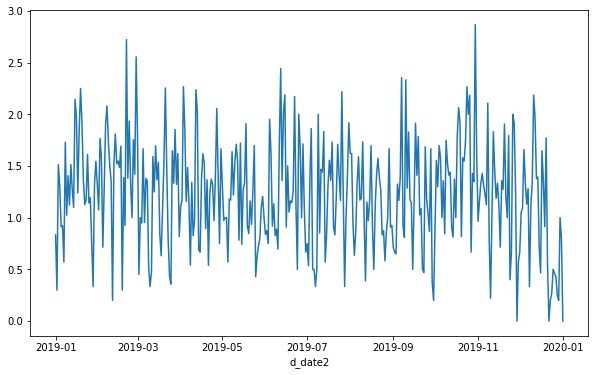

In [39]:
# group by date and calculate mean
daily_mean = df_plots.groupby('d_date2')['n_left'].mean()

# plot the result
plt.figure(figsize=(10,6))
daily_mean.plot()
plt.show()

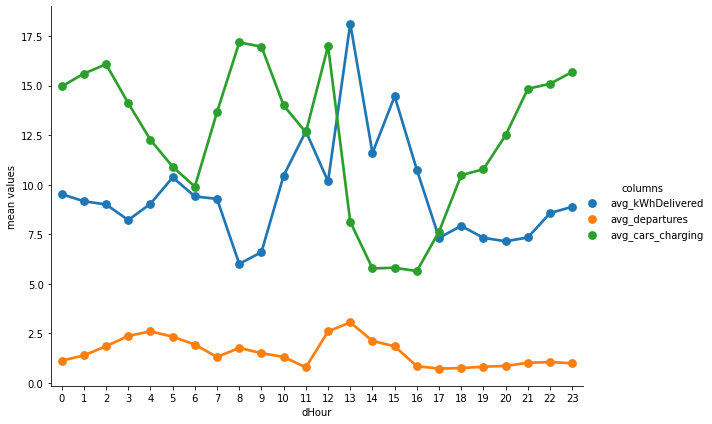

In [40]:
df_plots['dHour'] = (df_plots['disconnectTime'].dt.hour // 1) #Assigning the departure to standard hour in the day
#df1
hour_mean = df_plots.groupby('dHour').agg({'kWhDelivered':'mean','n_left':'mean','cars' :'mean'}) # calculating the mean values for each hour for the year 2019
hour_mean = pd.DataFrame({'dHour': hour_mean.index, 'avg_kWhDelivered': hour_mean.kWhDelivered, 'avg_departures':hour_mean.n_left, 'avg_cars_charging':hour_mean.cars }) # Creating a dataframe of the hourly mean values
hour_mean_plot = hour_mean.melt('dHour', var_name='columns', value_name='mean values') #processing the dataframe/ rearranging the data for plotting the graph
g = sns.catplot(x='dHour', y='mean values', hue='columns', data=hour_mean_plot, kind='point', height=6, aspect=1.5)
g.fig.set_size_inches(10,6)


In [41]:
# fig, ax1 = plt.subplots(figsize=(10,6))
# g = sns.lineplot(x='Hours', y='Average kWh Delivered', data=hour_mean,label='kWh Delivered', ax=ax1)
# plt.legend(loc = 'upper left')

# ax2 = ax1.twinx()
# sns.lineplot(x='Hours', y='Average Departures', data=hour_mean, color='red', label='Departures', ax=ax2)
# plt.legend(loc = 'upper right')

# plt.show()


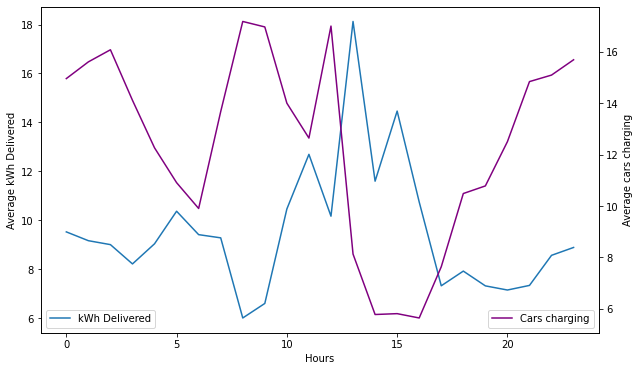

In [42]:
hour_mean = df_plots.groupby('dHour').agg({'kWhDelivered':'mean','n_left':'mean','cars' :'mean'}) # calculating the mean values for each hour for the year 2019
hour_mean = pd.DataFrame({'Hours': hour_mean.index, 'Average kWh Delivered': hour_mean.kWhDelivered, 'Average Departures':hour_mean.n_left, 'Average cars charging':hour_mean.cars }) # Creating a dataframe of the hourly mean values
hour_mean_plot = hour_mean.melt('Hours', var_name='columns', value_name='mean values') #processing the dataframe/ rearranging the data for plotting the graph
#g = sns.catplot(x='dHour', y='mean values', hue='columns', data=hour_mean_plot, kind='point')

fig, ax1 = plt.subplots(figsize=(10, 6))
g = sns.lineplot(x='Hours', y='Average kWh Delivered', data=hour_mean,label='kWh Delivered', ax=ax1)
plt.legend(loc='lower left')
ax2 = ax1.twinx()
sns.lineplot(x='Hours', y='Average cars charging', data=hour_mean, color='purple', label='Cars charging', ax=ax2)
plt.legend(loc='lower right')

plt.show()


<Figure size 720x432 with 0 Axes>

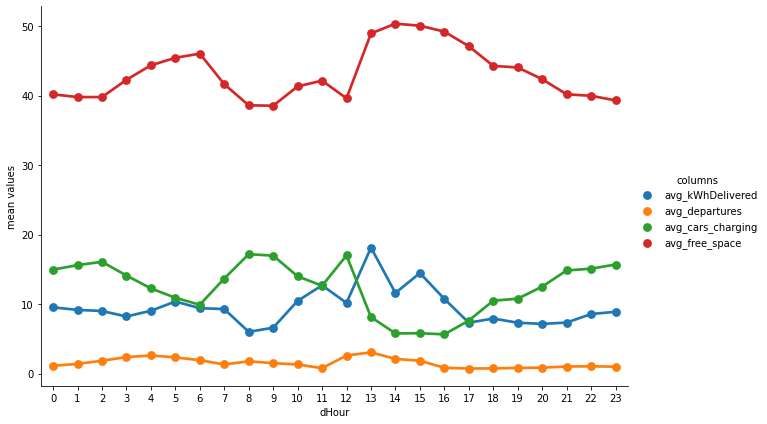

<Figure size 720x432 with 0 Axes>

In [43]:

#df1
hour_mean = df_plots.groupby('dHour').agg({'kWhDelivered':'mean','n_left':'mean','cars' :'mean'}) # calculating the mean values for each hour for the year 2019
hour_mean = pd.DataFrame({'Hour of the day': hour_mean.index, 'kWhDelivered': hour_mean.kWhDelivered, 'Departures':hour_mean.n_left, 'Cars currently charging':hour_mean.cars, 'No. of Charging space available': 54-hour_mean.cars + hour_mean.n_left}) # Creating a dataframe of the hourly mean values
hour_mean_plot = hour_mean.melt('Hour of the day', var_name='columns', value_name='Hourly Average') #processing the dataframe/ rearranging the data for plotting the graph
g = sns.catplot(x='Hour of the day', y='Hourly Average', hue='columns', data=hour_mean_plot, kind='point', height=6, aspect=1.5)
g._legend.set_title('Parameters')

plt.figure(figsize=(10,6))
#hour_mean

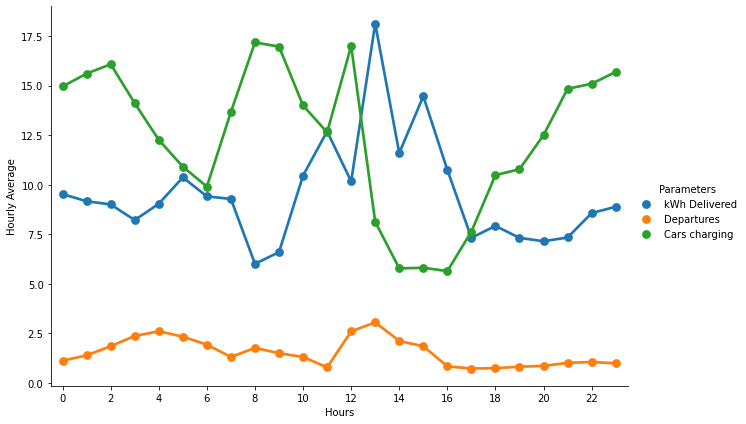

In [44]:
hour_mean = df_plots.groupby('dHour').agg({'kWhDelivered':'mean','n_left':'mean','cars' :'mean'}) # calculating the mean values for each hour for the year 2019
hour_mean = pd.DataFrame({'Hours': hour_mean.index, 'kWh Delivered': hour_mean.kWhDelivered, 'Departures':hour_mean.n_left, 'Cars charging':hour_mean.cars }) # Creating a dataframe of the hourly mean values
hour_mean_plot = hour_mean.melt('Hours', var_name='columns', value_name='Hourly Average') #processing the dataframe/ rearranging the data for plotting the graph
x_ticks = range(0, 24, 2)
g = sns.catplot(x='Hours', y='Hourly Average', hue='columns', data=hour_mean_plot, kind='point', height=6, aspect=1.5)
g._legend.set_title('Parameters')
plt.gca().set_xticks(range(0, 24, 2))
plt.show()

#hour_mean

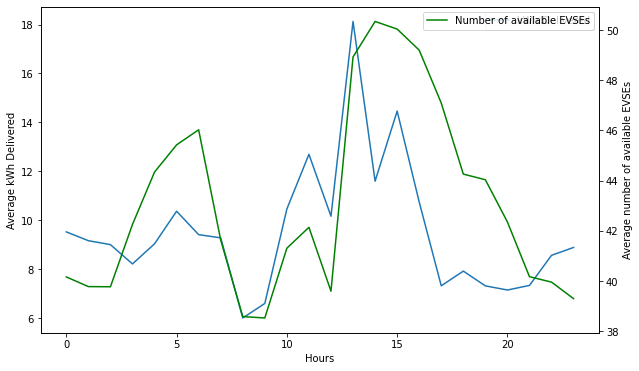

In [45]:
hour_mean = df_plots.groupby('dHour').agg({'kWhDelivered':'mean','n_left':'mean','cars' :'mean'}) # calculating the mean values for each hour for the year 2019
hour_mean = pd.DataFrame({'Hours': hour_mean.index, 'Average kWh Delivered': hour_mean.kWhDelivered,'Average number of available EVSEs': 54-hour_mean.cars + hour_mean.n_left}) #'Average Departures':hour_mean.n_left, 'Average cars charging(currently)':hour_mean.cars }) # Creating a dataframe of the hourly mean values
hour_mean_plot = hour_mean.melt('Hours', var_name='columns', value_name='Hourly Average') #processing the dataframe/ rearranging the data for plotting the graph
x_ticks = range(0, 24, 2)
plt.figure(figsize=(10,6))
g = sns.lineplot(x='Hours', y='Average kWh Delivered', data=hour_mean,label='kWh Delivered')
ax2 = plt.twinx()
sns.lineplot(x='Hours', y='Average number of available EVSEs', data=hour_mean, color='green' , label='Number of available EVSEs',ax=ax2)
plt.legend()

plt.show()


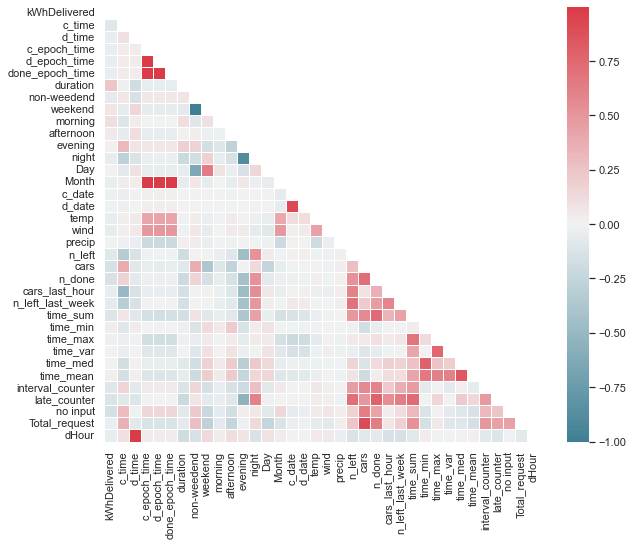

In [46]:
corr = df_plots.corr()
sns.set(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5)
plt.show()

# Heuristic for feature selection

In [1]:
'''

def relu(x):
    return np.maximum(x, 0)

class NonNegativeRegressor(MLPRegressor):
    def __init__(self, hidden_layer_sizes=(100,), activation='relu', solver='adam',   #hidden_layer_sizes=(1,100) this means(1 layer of 1 neuron and 2nd layer of 100 neurons)
                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001,
                 power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=1e-4, verbose=False,
                 warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
                 validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8, n_iter_no_change=10,
                 max_fun=15000):
        super().__init__(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver,
                         alpha=alpha, batch_size=batch_size, learning_rate=learning_rate,
                         learning_rate_init=learning_rate_init, power_t=power_t, max_iter=max_iter,
                         shuffle=shuffle, random_state=random_state, tol=tol, verbose=verbose,
                         warm_start=warm_start, momentum=momentum, nesterovs_momentum=nesterovs_momentum,
                         early_stopping=early_stopping, validation_fraction=validation_fraction,
                         beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, n_iter_no_change=n_iter_no_change,
                         max_fun=max_fun)
        self.out_activation_ = 'relu'
        self.feature_names_out_ = None
        self.coef_ = None
        
    def fit(self, X, y):
        y_non_negative = relu(y)
        super().fit(X, y_non_negative)
        self.feature_names_out_ = ["output_feature_{}".format(i) for i in range(self.n_outputs_)]
        self.coef_ = self.coefs_
        
    def predict(self, X):
        y_pred = super().predict(X)
        return relu(y_pred)
    
    def get_feature_importances(self, X):
        # Get the weights of the input layer
        weights = self.coefs_[0]

        # Compute the absolute values of the weights
        abs_weights = np.abs(weights)

        # Compute the importance scores for each feature
        feature_importances = np.sum(abs_weights, axis=0)

        # Normalize the importance scores so that they sum to 1
        feature_importances /= np.sum(feature_importances)

        return feature_importances

        '''

'\n\ndef relu(x):\n    return np.maximum(x, 0)\n\nclass NonNegativeRegressor(MLPRegressor):\n    def __init__(self, hidden_layer_sizes=(100,), activation=\'relu\', solver=\'adam\',   #hidden_layer_sizes=(1,100) this means(1 layer of 1 neuron and 2nd layer of 100 neurons)\n                 alpha=0.0001, batch_size=\'auto\', learning_rate=\'constant\', learning_rate_init=0.001,\n                 power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=1e-4, verbose=False,\n                 warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,\n                 validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8, n_iter_no_change=10,\n                 max_fun=15000):\n        super().__init__(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver,\n                         alpha=alpha, batch_size=batch_size, learning_rate=learning_rate,\n                         learning_rate_init=learning_rate_init, power_t=power_t, max_ite

In [2]:
'''
train_nn.fit(X_train_scale, Y_train)
importances = train_nn.get_feature_importances(X_test_scale)

importances
importances.shape


weights_input_hidden = train_nn.coefs_[0]

weights_input_hidden

scaled_weights =  preprocessing.scale(weights_input_hidden)
weights = pd.DataFrame(scaled_weights) 
parameters =pd.DataFrame(['kWhDelivered', 'c_time', 'd_time', 'c_epoch_time', 'd_epoch_time',
       'done_epoch_time', 'duration', 'non-weedend', 'weekend', 'morning',
       'afternoon', 'evening', 'night', 'Day', 'Month', 'c_date', 'd_date',
       'temp', 'wind', 'precip', 'cars', 'n_done', 'cars_last_hour',
       'n_left_last_week', 'time_sum', 'time_min', 'time_max', 'time_var',
       'time_med', 'interval_counter','late_counter' 'late_counter', 'no input',
       'Total_request'])
#final = pd.concat([weights, parameters], axis=1,keys=["Weight", "Parameter"])
weights_input_full = train_nn.coefs_[0] #gives weights of the features in the 1st layer (input features to first )
#final.to_excel('weights 1,100,100 .xlsx', index=True)
'''

'\ntrain_nn.fit(X_train_scale, Y_train)\nimportances = train_nn.get_feature_importances(X_test_scale)\n\nimportances\nimportances.shape\n\n\nweights_input_hidden = train_nn.coefs_[0]\n\nweights_input_hidden\n\nscaled_weights =  preprocessing.scale(weights_input_hidden)\nweights = pd.DataFrame(scaled_weights) \nparameters =pd.DataFrame([\'kWhDelivered\', \'c_time\', \'d_time\', \'c_epoch_time\', \'d_epoch_time\',\n       \'done_epoch_time\', \'duration\', \'non-weedend\', \'weekend\', \'morning\',\n       \'afternoon\', \'evening\', \'night\', \'Day\', \'Month\', \'c_date\', \'d_date\',\n       \'temp\', \'wind\', \'precip\', \'cars\', \'n_done\', \'cars_last_hour\',\n       \'n_left_last_week\', \'time_sum\', \'time_min\', \'time_max\', \'time_var\',\n       \'time_med\', \'interval_counter\',\'late_counter\' \'late_counter\', \'no input\',\n       \'Total_request\'])\n#final = pd.concat([weights, parameters], axis=1,keys=["Weight", "Parameter"])\nweights_input_full = train_nn.coefs_[0